In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm  # progress meter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

Duplicate key in file '/Users/martin/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
diabetes = pd.read_csv('data/diabetes_v3.csv')
print("\n".join([*diabetes.columns]))

id
cholesterol
gluc
smoke
alco
active
diabetes
age
height
weight
gender
ind
pressure_high
pressure_low


In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
diabetes.head()

,id,cholesterol,gluc,smoke,alco,active,diabetes,age,height,weight,gender,ind,pressure_high,pressure_low
0,62538,0,0,0,0,1,0,54.0000,169.0000,76.0000,1,train,100.0000,80.0000
1,49159,0,0,0,0,1,0,49.0000,165.0000,65.0000,0,train,120.0000,82.0000
2,60683,0,0,0,0,1,0,60.1699,170.0000,56.0000,0,train,120.0000,80.0000
3,42924,0,0,0,0,0,0,55.5808,169.0000,62.0000,0,train,120.0000,80.0000
4,52888,0,0,0,0,0,0,44.3890,166.0000,67.0000,0,train,120.0000,80.0000


In [4]:
diabetes.describe().drop("count")

,id,cholesterol,gluc,smoke,alco,active,diabetes,age,height,weight,gender,pressure_high,pressure_low
mean,49973.4686,0.3680,0.2273,0.0879,0.0539,0.8033,0.2508,53.1829,164.3236,74.1938,0.3480,128.5207,96.8267
std,28845.5238,0.6812,0.5733,0.2832,0.2258,0.3975,0.4335,6.7691,8.2107,14.6389,0.4763,138.6072,190.8739
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,29.5836,55.0000,10.0000,0.0000,1.0000,0.0000
25%,25027.2500,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,48.2856,159.0000,64.0000,0.0000,120.0000,80.0000
50%,50004.5000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,53.9644,165.0000,71.0000,0.0000,120.0000,80.0000
75%,74876.7500,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,58.3342,170.0000,82.0000,1.0000,140.0000,90.0000
max,99999.0000,2.0000,2.0000,1.0000,1.0000,1.0000,1.0000,64.9342,250.0000,200.0000,1.0000,16020.0000,11000.0000


In [5]:
print(f"{diabetes.shape}")

(67682, 14)


In [6]:
print(diabetes.groupby('diabetes').size())

diabetes
0    50706
1    16976
dtype: int64


/Users/martin/dev/ML-with-Python/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='diabetes', ylabel='count'>

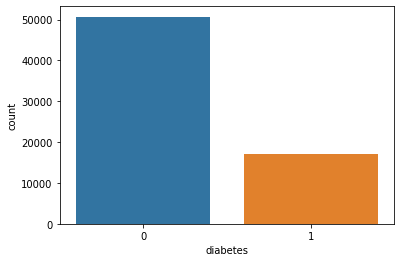

In [7]:
seaborn.countplot(diabetes['diabetes'], label="Count")

In [8]:
diabetes.groupby('diabetes').mean().T

diabetes,0,1
id,49895.4642,50206.4619
cholesterol,0.1895,0.9013
gluc,0.0407,0.7847
smoke,0.0766,0.1216
alco,0.0468,0.0750
active,0.8656,0.6172
age,52.1100,56.3874
height,163.6863,166.2273
weight,71.0550,83.5693
gender,0.2859,0.5333


In [9]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67682 entries, 0 to 67681
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             67682 non-null  int64  
 1   cholesterol    67682 non-null  int64  
 2   gluc           67682 non-null  int64  
 3   smoke          67682 non-null  int64  
 4   alco           67682 non-null  int64  
 5   active         67682 non-null  int64  
 6   diabetes       67682 non-null  int64  
 7   age            67682 non-null  float64
 8   height         67682 non-null  float64
 9   weight         67682 non-null  float64
 10  gender         67682 non-null  int64  
 11  ind            67682 non-null  object 
 12  pressure_high  67682 non-null  float64
 13  pressure_low   67682 non-null  float64
dtypes: float64(5), int64(8), object(1)
memory usage: 7.2+ MB


### Logistic regression

In [10]:
features = [
    'cholesterol', 
    'gluc', 
    'smoke', 
    'alco', 
    'active', 
    'age', 
    'height', 
    'weight', 
    'gender', 
    'pressure_high',
    'pressure_low'
]

Let's normalize the data before training the model. We normalize the test data with the feature min and feature max from the training data.

#### Train and test data

In [11]:
# Train data
X_train = diabetes[diabetes["ind"].eq("train")][features]
feature_min, feature_max = X_train.min(), X_train.max()

# Test data
X_test = diabetes[diabetes["ind"].eq("test")][features]

# Min-Max-Normalization
X_train = (X_train - feature_min)/(feature_max - feature_min)
X_test = (X_test - feature_min)/(feature_max - feature_min)

# Labels
y_train = diabetes[diabetes["ind"].eq("train")]["diabetes"]
y_test = diabetes[diabetes["ind"].eq("test")]["diabetes"]

#### Build the statistical model

In [12]:
import statsmodels.api as sm

stat_model = sm.Logit(y_train, X_train)
stat_model = stat_model.fit()
print(stat_model.summary())

Optimization terminated successfully.
         Current function value: 0.120424
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                58002
Model:                          Logit   Df Residuals:                    57991
Method:                           MLE   Df Model:                           10
Date:                Mon, 18 Oct 2021   Pseudo R-squ.:                  0.7860
Time:                        21:36:17   Log-Likelihood:                -6984.8
converged:                       True   LL-Null:                       -32634.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
cholesterol       4.6631      0.078     59.426      0.000       4.509       4.817
gluc             12

#### Build the prediction model

In [13]:
from sklearn.linear_model import LogisticRegression

# Build the model
logistic_regression = LogisticRegression()
logistic_regression = logistic_regression.fit(X_train, y_train)

# Predict test and train data
accuracy = {}
accuracy["train"] = logistic_regression.score(X_train, y_train)
accuracy["test"] = logistic_regression.score(X_test, y_test)
print(f'Train accuracy: {accuracy["train"]:.4f}')
print(f'Test accuracy: {accuracy["test"]:.4f}')

# Predict test data
pred_diabetes_prob = logistic_regression.predict_proba(X_test)[:,1]
y_pred = pred_diabetes_prob > 0.5

Train accuracy: 0.9558
Test accuracy: 0.9548


### Inspect classification result

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7220
           1       0.94      0.88      0.91      2460

    accuracy                           0.95      9680
   macro avg       0.95      0.93      0.94      9680
weighted avg       0.95      0.95      0.95      9680



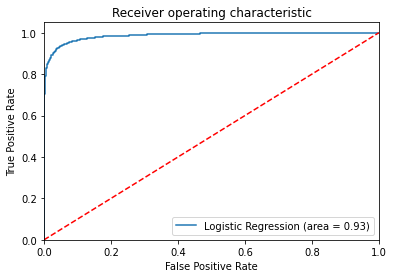

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc_scores = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, pred_diabetes_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_scores)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()